<a href="https://colab.research.google.com/github/gmauricio-toledo/NLP-MCD/blob/main/11_BERT_SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>BERT</h1>

En esta notebook exploraremos el uso de modelos tipo BERT para resolver la tarea de *Análisis de Sentimientos*. Esto lo haremos de dos formas:

1. Haciendo fine-tuning a un modelo BERT.
2. Usando los embeddings generados por BERT como features para un algoritmo de ML.

Usaremos modelos pre-entrenados almacenados en [HuggingFace](https://huggingface.co/).

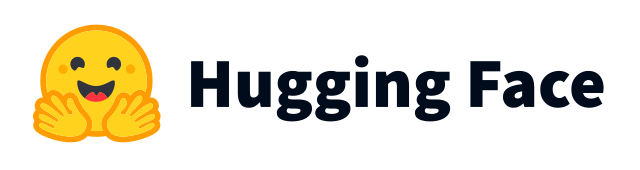

---

*Hugging Face, Inc. es una empresa estadounidense conocida por su biblioteca de transformadores creada para aplicaciones de procesamiento de lenguaje natural y su plataforma que permite a los usuarios compartir [datasets](https://huggingface.co/datasets) y [modelos](https://huggingface.co/models) de aprendizaje automático.  Su campo de acción principal es el NLP, pero también se centra en otras áreas del ML, como la visión de máquina, el aprendizaje por refuerzo y el aprendizaje supervisado.*

---

Regresaremos al dataset de 50K reviews de [IMDB](https://www.imdb.com/). Recordemos los rendimientos que habíamos obtenido:

* **Naive Bayes y ML clásico**. Accuracy: $\sim$ 75-82%.
* **Embeddings de Word2Vec, GloVe, Doc2Vec**. Accuracy: $\sim$ 85-87%.
* **BERT**: Accuracy $\sim$ ❓

# 1. Dataset

In [3]:
!gdown 18kGdlhOiQNS61wUK7uPbdquKL3XJrgzf

Downloading...
From: https://drive.google.com/uc?id=18kGdlhOiQNS61wUK7uPbdquKL3XJrgzf
To: /content/IMDB.csv
100% 66.2M/66.2M [00:02<00:00, 32.6MB/s]


Leemos el dataset y hacemos la división en

* Entrenamiento: 30,000
* Validación: 10,000
* Prueba: 10,000

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

imdb_df = pd.read_csv('IMDB.csv')
display(imdb_df)

y = LabelEncoder().fit_transform(imdb_df['sentiment'].values)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(imdb_df['review'].values, y, test_size=0.2, random_state=642, stratify=y)
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X_train_raw, y_train, test_size=0.25, random_state=473, stratify=y_train)
print(f"Training set size: {len(X_train_raw)}")
print(f"Validation set size: {len(X_val_raw)}")
print(f"Test set size: {len(X_test_raw)}")

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Training set size: 30000
Validation set size: 10000
Test set size: 10000


In [10]:
import numpy as np

random_idxs = np.random.choice(len(X_train_raw), size=4, replace=False)

for k in random_idxs:
    print(f"Review:\n{X_train_raw[k]}")

Review:
Complete drivel. An unfortunate manifestation of the hypocritical, toxic culture of a decade ago. In this movie, pedestrian regrets for slavery go hand in hand with colonialist subtexts (the annoying redhead feeding Shaka rice?). Forget historical reality too. Didn't most western slaves comes from West Africa? An American slaver easily capturing Shaka with a handful of men?. Finally, David Hasslehoff could not have been any more obnoxious. One can only ponder, how would he have fared in the miniseries? (Promptly impaled most likely). The miniseries was superb, and it is unfortunate that DH should have gotten his hands on something unique, and made it mundane. (I tend to think that he had hand in creating this fiasco).
Review:
My sisters and my cousin(female) forced me to see this chick movie. Its not the kind of movie I would prefer to see, but it really wasn't that bad. I wouldn't want to see this movie, but after watching it I couldn't say it was bad, just not my kind of film

#2. Limpieza y preprocesamiento

En los modelos de lenguaje modernos como BERT y sus sucesores, el preprocesamiento tradicional del texto (como la eliminación de stopwords, lematización o stemming) ya no es necesario ni recomendable.

Estos modelos están diseñados para entender el contexto y la estructura del lenguaje tal como aparece en el texto crudo, incluyendo palabras funcionales que aportan significado contextual.

Sin embargo, sí es común limpiar el texto de artefactos no lingüísticos, como etiquetas HTML, códigos de escape, URLs, o caracteres especiales irrelevantes.

En su lugar, el preprocesamiento se limita generalmente a la tokenización mediante el tokenizador específico del modelo (por ejemplo, WordPiece para BERT), la adición de tokens especiales ([CLS], [SEP]), y el relleno o truncamiento de secuencias para ajustarlas a una longitud fija.

Conservar el texto original permite al modelo aprovechar al máximo su capacidad contextual y semántica.

In [7]:
import re
import html

def clean_text(text):
    # Decodificar entidades HTML
    text = html.unescape(text)
    # Eliminar etiquetas HTML
    text = re.sub(r'<[^>]+>', ' ', text)
    # Normalizar espacios
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [8]:
train_docs = [clean_text(doc) for doc in X_train_raw]
test_docs = [clean_text(doc) for doc in X_test_raw]
val_docs = [clean_text(doc) for doc in X_val_raw]

In [11]:
for k in random_idxs:
    print(f"Review:\n{train_docs[k]}")

Review:
Complete drivel. An unfortunate manifestation of the hypocritical, toxic culture of a decade ago. In this movie, pedestrian regrets for slavery go hand in hand with colonialist subtexts (the annoying redhead feeding Shaka rice?). Forget historical reality too. Didn't most western slaves comes from West Africa? An American slaver easily capturing Shaka with a handful of men?. Finally, David Hasslehoff could not have been any more obnoxious. One can only ponder, how would he have fared in the miniseries? (Promptly impaled most likely). The miniseries was superb, and it is unfortunate that DH should have gotten his hands on something unique, and made it mundane. (I tend to think that he had hand in creating this fiasco).
Review:
My sisters and my cousin(female) forced me to see this chick movie. Its not the kind of movie I would prefer to see, but it really wasn't that bad. I wouldn't want to see this movie, but after watching it I couldn't say it was bad, just not my kind of film

# 3. Finetuning del modelo BERT - **Deprecated**

Exploraremos dos modelos de BERT:

* [`bert-base-uncased`](https://huggingface.co/google-bert/bert-base-uncased): Es el modelo *pequeño*, tiene 110M de parámetros. Su uso estará comentado.
* [`distilbert-base-uncased`](https://huggingface.co/distilbert/distilbert-base-uncased): Versión más pequeña de BERT, tiene 67M de parámetros.

Dado el tamaño del dataset y lo *grande* del modelo probaremos dos estrategias:

1. Limitaremos el entrenamiento a unos pocos miles de ejemplos, estratificados de acuerdo a sus etiquetas.
2. Mostraremos el comportamiento con el dataset de entrenamiento completo.

In [6]:
num_training_docs = 2000
num_validation_docs = 1000

sample_train_docs, _, sample_train_labels, _ = train_test_split(train_docs, y_train,
                                                                train_size=num_training_docs,
                                                                random_state=777,
                                                                stratify=y_train)

sample_val_docs, _, sample_val_labels, _ = train_test_split(val_docs, y_val,
                                                            train_size=num_validation_docs,
                                                            random_state=777,
                                                            stratify=y_val)

Un modelo de BERT se compone de dos mitades: el tokenizador y el modelo BERT.

## 3.1. Tokenización


Los modelos basados en transformadores tokenizan subpalabras, un enfoque iniciado con `FastText`. El algoritmo se llama wordpiece, fue desarrollado por Google ([más información](https://huggingface.co/learn/nlp-course/chapter6/6)).

Los tokenizadores que usaremos son, respectivamente:

* [BertTokenizer](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizer).
* [DistilBertTokenizerFast](https://huggingface.co/docs/transformers/model_doc/distilbert#transformers.DistilBertTokenizer).

In [7]:
from transformers import BertTokenizer
from transformers import DistilBertTokenizerFast

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Tokenizamos los conjuntos de datos.

**Observación**: El tokenizador no se entrena en el conjunto de datos.

In [8]:
train_encodings = tokenizer(sample_train_docs, truncation=True, padding=True)
val_encodings = tokenizer(sample_val_docs, truncation=True, padding=True)
test_encodings = tokenizer(test_docs, truncation=True, padding=True)

In [9]:
tokenizer.vocab_size

30522

In [10]:
tokenizer.model_max_length, print(len(train_encodings['input_ids'][0]))

512


(512, None)

Exploremos el vocabulario, ya no son palabras solamente, en el sentido usual.

In [11]:
tokenizer.get_vocab()

{'everest': 23914,
 '##sfield': 15951,
 'payne': 13470,
 'notably': 5546,
 'nerve': 9113,
 '##rrell': 14069,
 'dodd': 21258,
 'commuter': 14334,
 '##enna': 24397,
 'taps': 25316,
 'notification': 26828,
 'moroccan': 17494,
 '[SEP]': 102,
 'eagerly': 17858,
 '##hart': 10686,
 'sampling': 16227,
 '##iling': 16281,
 'romano': 22070,
 'martin': 3235,
 'vaults': 28658,
 'ascent': 16354,
 'takahashi': 25585,
 'robbie': 12289,
 'compilation': 6268,
 'wolverhampton': 20085,
 'duck': 9457,
 'appetite': 18923,
 'short': 2460,
 'output': 6434,
 '##puri': 24661,
 'obscured': 23649,
 'taken': 2579,
 'steven': 7112,
 'ev': 23408,
 'mclaren': 18590,
 '分': 1775,
 '里': 1962,
 'reprised': 22598,
 '[unused790]': 795,
 'nectar': 24816,
 'ken': 6358,
 'agatha': 23863,
 'transcript': 24051,
 'ui': 21318,
 'concourse': 28571,
 'interlude': 25347,
 'psychic': 12663,
 'ravens': 17272,
 'adhere': 25276,
 'campo': 22339,
 'opposes': 29158,
 'sparked': 13977,
 'terms': 3408,
 'pace': 6393,
 'rogers': 7369,
 'ryan

Veamos un ejemplo de tokenización

In [12]:
print(sample_train_docs[0])
for idx in train_encodings['input_ids'][0]:
    print(f"{idx}: {tokenizer.decode(idx)}")


THIS FILM IS LAME LAME LAME It takes lot bring over-exaggeration movie movie stunk house I n't even finished movie yet I stop comment bad movie I 'VE NEVER DONE THAT As consumer spend money film Wait comes cable channel something It 's barely TV worthy I REALLY HATE TRASHING A MOVIE BUT THIS MOVIE IS TRASH Barely porn Should X rating Good plot frontal nudity floats boat HORRIBLE high school level acting Do n't know movie received distribution Must contractual thing Really really like watching good movies n't waste time one From one movie lover another YOU WILL BE MAD AT YOURSELF Let say well 've something like perhaps relate value In case I say watch may take something away seeing something 's happened acted someone else therapeutic value
101: [CLS]
2023: this
2143: film
2003: is
20342: lame
20342: lame
20342: lame
2009: it
3138: takes
2843: lot
3288: bring
2058: over
1011: -
4654: ex
27609: ##agger
3370: ##ation
3185: movie
3185: movie
24646: stu
8950: ##nk
2160: house
1045: i
1050: n

## 3.2 Fine-Tuning

Construimos los datasets

In [13]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    sample_train_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    sample_val_labels
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [14]:
!pip install -qq transformers tensorflow
# !pip install transformers tensorflow keras

Exploraremos dos estrategias para hacer el fine-tuning:

* **(1)** Entrenar con todo el conjunto de entrenamiento del dataset y evaluar con todo el conjunto de prueba.
* **(2)** Entrenar con una parte pequeña del conjunto de entrenamiento y evaluar con todo el conjunto de prueba.

Para los entrenamientos usaremos dos maneras:

* **(A)** Usando el módelo BERT como un modelo de Keras, entrenado con el método `fit`. Esta puede usar `Tensorflow` o `Pytorch`.
* **(B)** Usando la API de la libreria `Transformers` de HuggingFace, `Trainer`. Forzosamente usando `Pytorch`.

### Estrategia 1

In [15]:
import tensorflow as tf

# from transformers import TFBertForSequenceClassification
from transformers import TFDistilBertForSequenceClassification

# model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


TypeError: 'builtins.safe_open' object is not iterable

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
# early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=3)

# Train the model
history = model.fit(
    train_dataset.batch(8),
    epochs=3,
    batch_size=8,
    validation_data=val_dataset.batch(8),
    # callbacks=[early_stopping_callback]
)

⚡ Resultados

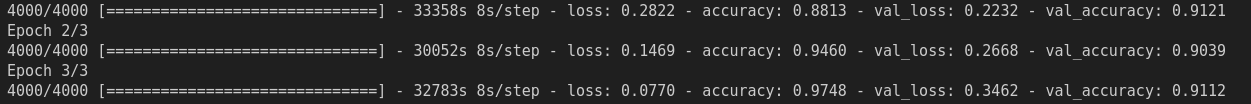

El modelo muestra tendencia de comenzar a subir el rendimiento a la par del entrenamiento

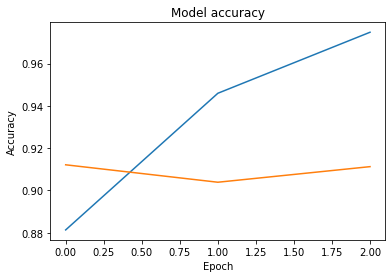

Obtuvimos un $\sim$90% de accuracy en el conjunto de prueba. Superando el rendimiento de las métodos anteriores.

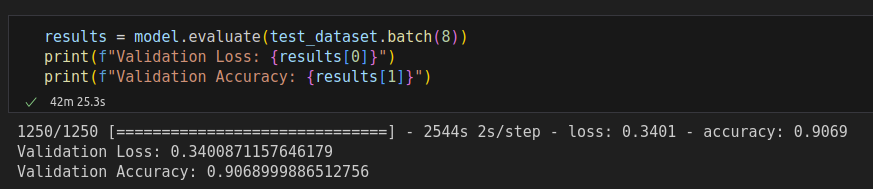

### Estrategia 2


Obtuvimos rendimientos similares al enfoque usando `doc2vec`

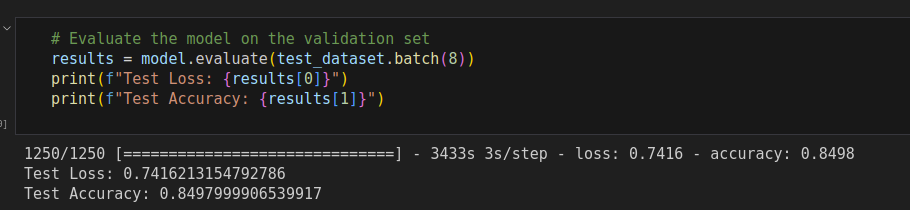

In [ ]:
from transformers import BertTokenizer
from transformers import DistilBertTokenizerFast

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
train_encodings = tokenizer(sample_train_docs, truncation=True, padding=True)
val_encodings = tokenizer(sample_val_docs, truncation=True, padding=True)
test_encodings = tokenizer(test_docs, truncation=True, padding=True)

In [ ]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    sample_train_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    sample_val_labels
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [ ]:
from transformers import TFDistilBertForSequenceClassification

# model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
history = model.fit(
    train_dataset.batch(8),
    epochs=4,
    batch_size=8,
    validation_data=val_dataset.batch(8),
    # callbacks=[early_stopping_callback]
)

# Finetuning con la clase [`Trainer`](https://huggingface.co/docs/transformers/main_classes/trainer) de transformers

`Trainer` es una API de HuggingFace para hacer fine-tuning a modelos para tareas específicas. Hay dos variantes:

* **`Trainer`**: API basada en Pytorch. Usaremos esta
* **`TFTrainer`**: API basada en Tensorflow. Obsoleta, ya no se encuentra en la versión más reciente de transformers.

Se requiere que definamos 2 objetos:

* [`TrainingArguments`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments): Especifica los hiperparámetros de entrenamiento. Todas las opciones se pueden encontrar en [docs](https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments). Por ejemplo, especificamos que queremos evaluar después de cada epoch de entrenamiento, nos gustaría guardar el modelo cada epoch, establecemos la tasa de aprendizaje, el tamaño del lote a utilizar para el entrenamiento/evaluación, para cuántas epochs entrenar, etc.
* `Trainer`: [Docs](https://huggingface.co/transformers/main_classes/trainer.html#id1).


## Preparación del dataset

In [25]:
num_training_docs = 2000
num_validation_docs = 1000

sample_train_docs, _, sample_train_labels, _ = train_test_split(train_docs, y_train,
                                                                train_size=num_training_docs,
                                                                random_state=777,
                                                                stratify=y_train)

sample_val_docs, _, sample_val_labels, _ = train_test_split(val_docs, y_val,
                                                            train_size=num_validation_docs,
                                                            random_state=777,
                                                            stratify=y_val)

sample_test_docs, _, sample_test_labels, _ = train_test_split(test_docs, y_test,
                                                              train_size=num_validation_docs,
                                                              random_state=777,
                                                              stratify=y_test)

In [26]:
train_df = pd.DataFrame(data={
                        # 'text': train_docs,
                        'text': sample_train_docs,
                        # 'label': y_train
                        'label': sample_train_labels
                    })

val_df = pd.DataFrame(data={
                        # 'text': val_docs,
                        'text': sample_val_docs,
                        # 'label': y_val
                        'label': sample_val_labels
                    })

test_df = pd.DataFrame(data={
                        'text': test_docs,
                        'label': y_test
                    })

train_df

,text,label
0,"THIS FILM IS LAME, LAME, LAME!!!!! It takes a ...",0
1,** May contain spoilers ** Horrible. Just horr...,0
2,It must be the most corniest TV show on the ai...,0
3,**** MILD SPOILERS _ BUT YOU PROBABLY KNOW THE...,0
4,I found the film Don't Look In The Basement to...,1
...,...,...
1995,"Acting was weak, but in a horror flick, I can ...",0
1996,Not only was this movie better than all the fi...,1
1997,"This is one of my all time favorite movies, it...",1
1998,Ever have one of those sneezes that seems to b...,0


In [17]:
!pip install -qq datasets

In [27]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

## Tokenización

In [28]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Tamaño de vocabulario:

In [ ]:
tokenizer.vocab_size

Inspeccionemos el vocabulario:

In [ ]:
tokenizer.get_vocab()

In [29]:
# Función para tokenizar los textos
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

tokenized_train_dataset.set_format("torch")
tokenized_val_dataset.set_format("torch")
tokenized_test_dataset.set_format("torch")


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
train_df.iloc[0]['text']

In [ ]:
sample_text = '''THIS FILM IS LAME, LAME, LAME!!!!! It takes a'''
sample_encodings = tokenize_function(sample_text)
# tokenizer.decode(sample_encodings['input_ids'])

tokenizer.model_max_length, print(len(sample_encodings['input_ids']))

## Finetuning

In [30]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased",
                                                           num_labels=2
                                                           )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc}

In [32]:
from transformers import TrainingArguments

batch_size = 8
metric_name = 'accuracy'
num_epocas = 1

args = TrainingArguments(
    output_dir=f"bert-finetuning",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epocas,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    report_to="none"
)


In [33]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-2765937096.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

In [ ]:
eval_results = trainer.evaluate(eval_dataset=tokenized_test_dataset)
print(f"Test Evaluation Results: {eval_results}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


In [ ]:
# Save the entire model as a HDF5 file
model.save_pretrained("BERT_saved_model")

# Optionally, if you also want to save the tokenizer used during training
tokenizer.save_pretrained("BERT_saved_model_tokenizer")

Visualizando la atención:

https://huggingface.co/spaces/exbert-project/exbert

# Embeddings

En este caso usaremos los embeddings generados por un módelo BERT pre-entrenado como features para un algoritmo de ML.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Con esta función obtenemos los embeddings de cada texto

In [ ]:
import torch

device = torch.device("cpu")  # Define el dispositivo como CPU
model.to(device)  # Mueve el modelo a la CPU

def get_cls_embedding(texts, verbose=False):
    # Tokeniza los textos: padding, truncamiento y conversión a tensores PyTorch
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)

    if verbose:
        # Calcula la longitud real de tokens (excluyendo padding)
        tokenized_length = len([idx for idx in encoded_input['input_ids'][0]
                               if idx != 0])
        print(f'Tokenized length: {tokenized_length}')

    # Mueve todos los inputs tokenizados al dispositivo (CPU/GPU)
    encoded_input = {key: value.to(device) for key, value in encoded_input.items()}

    # Desactiva el cálculo de gradientes para inferencia (más eficiente)
    with torch.no_grad():
        # Pasa los inputs por el modelo y obtiene todas las salidas
        model_output = model(**encoded_input, output_hidden_states=True)

    if verbose:
        # Muestra la forma del último layer de hidden states
        print(model_output['hidden_states'][-1].shape)

    # Extrae el embedding del token [CLS] (posición 0) del último layer
    cls_embeddings = model_output['hidden_states'][-1][:, 0, :]

    # Convierte a numpy array para uso fuera de PyTorch
    return cls_embeddings.numpy()

Imprimamos información sobre las formas de las salidas para ilustrar lo que estamos obteniendo:

In [ ]:
_ = get_cls_embedding(sample_train_docs[0],verbose=True)

Tokenized length: 149
torch.Size([1, 149, 768])


In [ ]:
import numpy as np

train_embeddings = np.zeros((len(sample_train_docs), 768))

for i, text in enumerate(sample_train_docs):
    train_embeddings[i] = get_cls_embedding(text).reshape(-1,)

In [ ]:
val_embeddings = np.zeros((len(sample_val_docs), 768))

for i, text in enumerate(sample_val_docs):
    val_embeddings[i] = get_cls_embedding(text).reshape(-1,)

Podemos leerlos los que ya hemos generado previamente

In [ ]:
!gdown 1Cro8bXTjevcsTn40fI6q73u1ZBE6FiXE
!gdown 1Ob_vDLKZ3t9CCmgDqR0K6aqYm7Ainr6d
!gdown 1-B4yLyGj6WTuvB-TNAg8b695STJFIrWQ
!gdown 1-9f0JobxEThc6BdYzzInGGRPXaMbmc9w

In [ ]:
import numpy as np

train_embeddings = np.load('imdb sample train embeddings bert.npy')
val_embeddings = np.load('imdb sample test embeddings bert.npy')
train_labels = np.load('imdb sample train labels.npy')
val_labels = np.load('imdb sample test labels.npy')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clfs = [
    RandomForestClassifier(),
    SVC(C=2),
    LogisticRegression(max_iter=10000)
]

names = [
    'Random Forest',
    'SVC',
    'Logistic Regression'
]

for name,clf in zip(names,clfs):
    pl = make_pipeline(StandardScaler(), clf)
    pl.fit(train_embeddings, train_labels)
    print(name, pl.score(val_embeddings, val_labels))

Random Forest 0.739
SVC 0.788
Logistic Regression 0.765


# 🔴 Tarea:

Usando otro modelo tipo BERT (DeBERTa, ALBERT, ELECTRA, etc), realiza la tarea de clasificación en el dataset de reviews de turismo en español.

Aquí hay dos desafios que explorar:

1. ¿Los modelos anteriores se pueden usar en español?
2. Buscar un modelo específico en español.

Para esta tarea, realiza una división *train/test* similar a la hecha en la práctica anterior con este dataset.

Para realizar el entrenamiento puedes usar la estrategia (1.A) o la clase `Trainer`.